In [1]:
import re
import pandas as df
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Split Data

In [2]:
train = df.read_csv('partitions/undersampledTrain.csv')
valid = df.read_csv('partitions/undersampledValid.csv')
test = df.read_csv('partitions/undersampledTest.csv')

Xtrain = train.drop(columns="Generated")
ytrain = train.drop(columns="Review")
Xvalid = valid.drop(columns="Generated")
yvalid = valid.drop(columns="Review")
Xtest = test.drop(columns="Generated")
ytest = test.drop(columns="Review")

### Analyze Split in Computer Generated and Human Written

In [3]:
print(ytrain['Generated'].value_counts())
print(ytest['Generated'].value_counts())
print(yvalid['Generated'].value_counts())

0    60700
1    60118
Name: Generated, dtype: int64
1    20466
0    19807
Name: Generated, dtype: int64
0    20175
1    20098
Name: Generated, dtype: int64


### Tokenization

In [5]:
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def processWord(word):
    return re.sub(r'\W+', '', word)


def createOneHotDict(x_train):
    word_set = set()
    stop_words = set(stopwords.words('english'))
    for sentence in x_train['Review'].values:
        sentence = str(sentence)
        for word in sentence.lower().split():
            word = processWord(word)
            if word not in stop_words and word != '' and word not in word_set:
                word_set.add(word)

    return {word:i+1 for i, word in enumerate(word_set)}

def tokenize(x_train, y_train, vocabulary):
    tokenized_x_train = [[vocabulary[processWord(word)] for word in str(sentence).lower().split() if processWord(word) in vocabulary] for sentence in x_train['Review'].values]
    return np.array(tokenized_x_train), np.array(y_train['Generated'].values)

In [7]:
processWord("$13 dollars")

'13dollars'

In [8]:
vocabulary = createOneHotDict(Xtrain)
Xtrain, ytrain = tokenize(Xtrain, ytrain, vocabulary)
Xvalid, yvalid = tokenize(Xvalid, yvalid, vocabulary)
Xtest, ytest = tokenize(Xtest, ytest, vocabulary)

C:\Users\John\AppData\Local\Temp\ipykernel_12528\887965443.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(tokenized_x_train), np.array(encoded_y_train), np.array(tokenized_x_valid), np.array(encoded_y_valid), np.array(tokenized_x_test), np.array(encoded_y_test), onehot_dict


### Analyze Split in Fake Reviews (Class 0) and Real Reviews (Class 1)

In [11]:
def padVectors(sentences, length):
    vectors = np.zeros((len(sentences), length), dtype=int)
    for i, sentence in enumerate(sentences):
        if len(sentence) != 0:
            l = min(length, len(sentence))
            vectors[i, -l:] = np.array(sentence)[:l]
    return vectors

In [12]:
Xtrain_padded = padVectors(Xtrain, 250)
Xvalid_padded = padVectors(Xvalid, 250)
Xtest_padded = padVectors(Xtest, 250)

### Create Datasets and DataLoaders

In [13]:
train_data = torch.utils.data.TensorDataset(torch.from_numpy(Xtrain_padded), torch.from_numpy(ytrain))
validation_data = torch.utils.data.TensorDataset(torch.from_numpy(Xvalid_padded), torch.from_numpy(yvalid))
test_data = torch.utils.data.TensorDataset(torch.from_numpy(Xtest_padded), torch.from_numpy(ytest))


# batch size for dataloaders
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [14]:
class ReviewClassifier(nn.Module):
    def __init__(self,vocab_size,embedding_dim, hidden_dim):
        super(ReviewClassifier,self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embedding layer
        embeds = self.embedding(x) 
        # LSTM layer
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        # Feed Forward Network
        out = self.fc(lstm_out)
        # sigmoid function
        sig_out = self.sigmoid(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        # create zero tensors for the hidden state and cell state of LSTM
        h0 = torch.zeros((1,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((1,batch_size,self.hidden_dim)).to(device)
        return (h0,c0)

In [15]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Create Model

In [16]:
vocabulary_size = len(vocabulary)+1
embedding_dim = 64
hidden_dim = 256

In [17]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.to(device)

print(model)

ReviewClassifier(
  (embedding): Embedding(125382, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Training

### Pretraining Guess on Test Example

In [18]:
with torch.no_grad():
    inputs = torch.from_numpy(Xtest_padded[35]).reshape(1,250).to(device)
    h= model.init_hidden(1)
    h = tuple([each.data for each in h])
    score, hidden = model(inputs, h)
    print("Score:", score.item())
    print(ytest[35])

Score: 0.5120322704315186
1


### Set Hyper Parameters

In [19]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.BCELoss()

def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

### Train Model

In [20]:
clip = 5
epochs = 25
valid_loss_min = np.Inf
valid_accuracy_max = np.NINF
training_loss, validation_loss, training_acc, valid_acc = [], [], [], []

In [21]:
for i in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(BATCH_SIZE)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        h = tuple([each.data for each in h])
        model.zero_grad()
        output, h = model(inputs, h)
        #calculate loss
        loss = criterion(output.squeeze(),labels.float())
        loss.backward()

        train_losses.append(loss.item())

        #accuracy
        train_acc += acc(output, labels)

        # prevent exploding gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(BATCH_SIZE)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in validation_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc += accuracy
    # Calculate average loss and the accuracies
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(validation_loader.dataset)

    training_loss.append(epoch_train_loss)
    validation_loss.append(epoch_val_loss)
    training_acc.append(epoch_train_acc)
    valid_acc.append(epoch_val_acc)
    print(f'Epoch {i+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    
    # Model Presenting Lowest Loss
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'best_loss_undersampled_state_dict.pt')
        print('Validation loss decreased ({:.5f} --> {:.5f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    # Model Presenting Highest Accuracy
    if epoch_val_acc >= valid_accuracy_max:
        torch.save(model.state_dict(), 'best_acc_undersampled_state_dict.pt')
        print('Validation accuracy increased ({:.5f} --> {:.5f}).  Saving model ...'.format(valid_accuracy_max,epoch_val_acc))
        valid_accuracy_max = epoch_val_acc
    print(25*'==')


Epoch 1
train_loss : 0.6736136103472383 val_loss : 0.645607211726269
train_accuracy : 57.003923256468404 val_accuracy : 63.03727062796415
Validation loss decreased (inf --> 0.64561).  Saving model ...
Validation accuracy increased (-inf --> 0.63037).  Saving model ...
Epoch 2
train_loss : 0.6399060297119725 val_loss : 0.6238550584532309
train_accuracy : 63.359764273535404 val_accuracy : 65.16028108161795
Validation loss decreased (0.64561 --> 0.62386).  Saving model ...
Validation accuracy increased (0.63037 --> 0.65160).  Saving model ...
Epoch 3
train_loss : 0.6198199773883466 val_loss : 0.6482990976357877
train_accuracy : 65.27090334221722 val_accuracy : 63.034787574801975
Epoch 4
train_loss : 0.6037016407989861 val_loss : 0.5964734574190573
train_accuracy : 66.75247065834562 val_accuracy : 67.67064782857001
Validation loss decreased (0.62386 --> 0.59647).  Saving model ...
Validation accuracy increased (0.65160 --> 0.67671).  Saving model ...
Epoch 5
train_loss : 0.5932368415812052

### Post-Training Guess on Example

In [22]:
with torch.no_grad():
  inputs = torch.from_numpy(Xtest_padded[35]).reshape(1,250).to(device)
  h= model.init_hidden(1)
  h = tuple([each.data for each in h])
  score, hidden = model(inputs, h)
  print("Score:", score.item())
  print(ytest[35])

Score: 0.9513936638832092
1


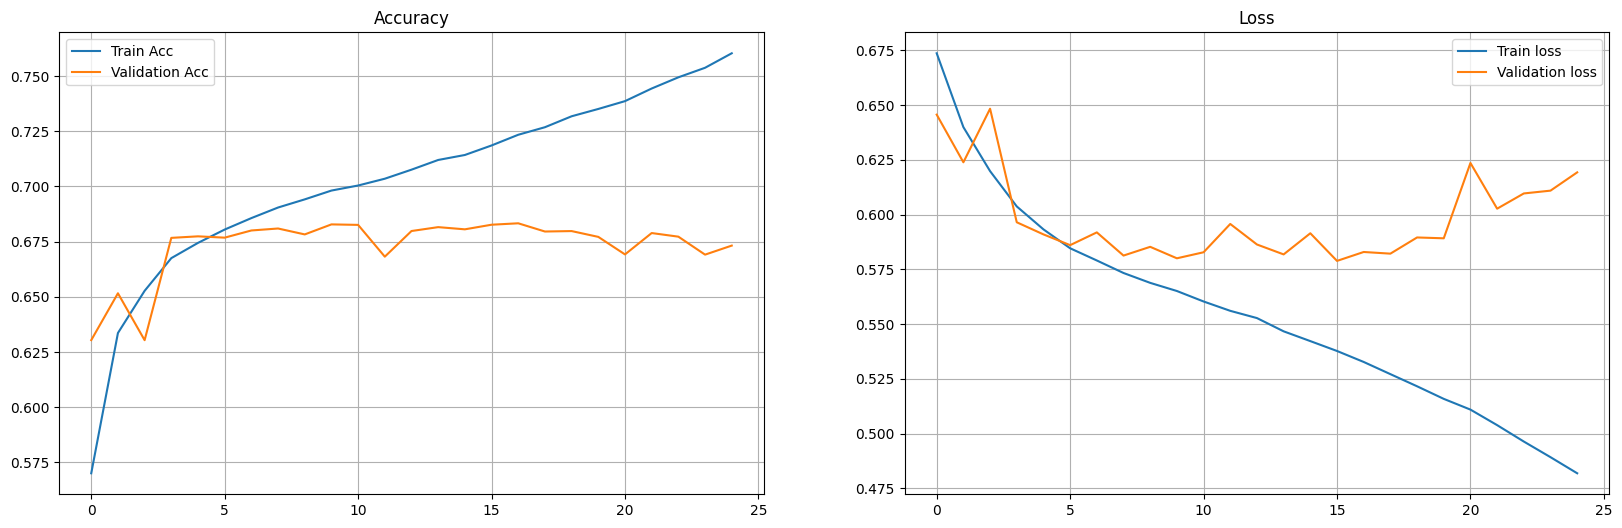

In [23]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(training_acc, label='Train Acc')
plt.plot(valid_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Calculate on Test and Display Confusion

In [24]:
def return_misses(inputs, output, labels, vocab):
    pred = torch.round(output.squeeze())
    labels = labels.squeeze()
    misses = []
    false_negative = 0
    false_positive = 0
    for i in range(len(pred)):
        if pred[i] != labels[i]:
            if pred[i] == 0:
                false_positive += 1
            else:
                false_negative += 1
        misses.append(' '.join([vocab[inputs[i][j].item()] for j in range(len(inputs[i])) if inputs[i][j].item() != 0]))
    return misses, false_negative, false_positive

def do_test_stats():
    test_h = model.init_hidden(32)
    test_losses = []
    test_acc = 0.0
    tot_misses = []
    model.eval()
    vocab_r = {v: k for k, v in vocabulary.items()}
    false_positives = 0
    false_negatives = 0
    tot_outputs = 0
    tot_labels = 0

    test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32, drop_last=True)
    with torch.no_grad():
        for inputs, labels in test_loader:
            test_h = tuple([each.data for each in test_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, test_h = model(inputs, test_h)
            test_loss = criterion(output.squeeze(), labels.float())

            test_losses.append(test_loss.item())
            misses, fneg, fpos = return_misses(inputs, output, labels, vocab_r)
            tot_misses.extend(misses)
            false_positives += fpos
            false_negatives += fneg
            accuracy = acc(output,labels)
            test_acc += accuracy

            tot_outputs = output if type(tot_outputs) == type(0) else torch.cat((tot_outputs, output))
            tot_labels = labels if type(tot_labels) == type(0) else torch.cat((tot_labels, labels))

    test_loss = np.mean(test_losses)
    test_acc = test_acc/len(test_loader.dataset)
    print(f'test_loss : {test_loss}')
    print(f'test_accuracy : {test_acc*100}')
    print(f'false_positive : {false_positives / len(test_loader.dataset)} ')
    print(f'false_negatives : {false_negatives / len(test_loader.dataset)} ')
    return tot_outputs, tot_labels
    
def display_confusion_matrix(tot_outputs, tot_labels):
    cm = confusion_matrix(tot_labels.cpu().data.numpy(), torch.round(tot_outputs.squeeze()).cpu().data.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [25]:
tot_outputs, tot_labels = do_test_stats()

test_loss : 0.6197830060043851
test_accuracy : 67.61105455267797
false_positive : 0.13999453728304323 
false_negatives : 0.18347279815260845 


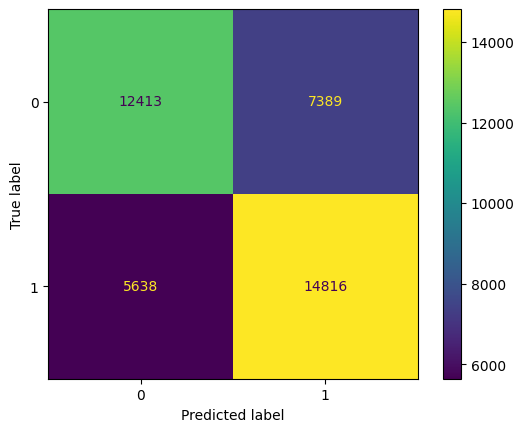

In [26]:
display_confusion_matrix(tot_outputs, tot_labels)

In [27]:
# Save final model
torch.save(model.state_dict(), 'post_training_undersampled_state_dict.pt')

### Save onehot dictionary

In [28]:
import pickle
with open("undersampled_onehot.pkl", "wb") as file:
    pickle.dump(vocabulary, file)

## Best Accuracy Model

### Evaluate Best Accuracy Model on Test Data

In [29]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_acc_undersampled_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(125382, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [30]:
tot_outputs, tot_labels = do_test_stats()

test_loss : 0.5832340399392648
test_accuracy : 68.52730116951804
false_positive : 0.15737590941822063 
false_negatives : 0.15692895984903038 


### Display Confusion Matrix

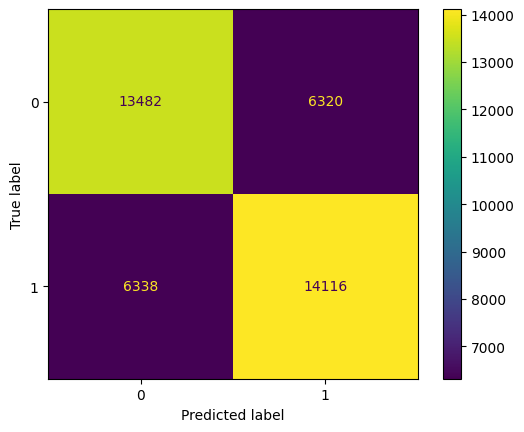

In [31]:
display_confusion_matrix(tot_outputs, tot_labels)

## Best Loss Model

### Evaluate Best Loss Model on Test Data

In [32]:
model = ReviewClassifier(vocabulary_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("best_loss_undersampled_state_dict.pt"))
model.to(device)
model.eval()

ReviewClassifier(
  (embedding): Embedding(125382, 64)
  (lstm): LSTM(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [33]:
tot_outputs, tot_labels = do_test_stats()

test_loss : 0.5766077215275438
test_accuracy : 68.57447917959924
false_positive : 0.1360464827551958 
false_negatives : 0.17778660641124328 


### Display Confusion Matrix

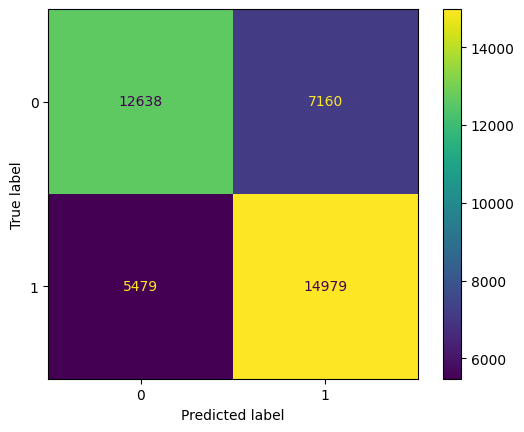

In [34]:
display_confusion_matrix(tot_outputs, tot_labels)